In [1]:
import os
import torch
os.environ['TRANSFORMERS_CACHE'] = '/mnt/software/'
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
warnings.filterwarnings("ignore")

device = "cuda"
model_id = "gpt2"

model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [64]:
def perplexity_score(inputs, stride=512, max_length = 512):

    lls = []
    for i in range(0, inputs.input_ids.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, inputs.input_ids.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = inputs.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids.to(device), labels=target_ids.to(device))
            log_likelihood = outputs[0] * trg_len

        lls.append(log_likelihood)

    ppl = torch.exp(torch.stack(lls).sum() / end_loc)
    return ppl.cpu().numpy()


train, val, test = load_dataset("csv", data_files="/mnt/software/flicc/Data/fallacy_train.csv"), load_dataset("csv", data_files="/mnt/software/flicc/Data/fallacy_val.csv"), load_dataset("csv", data_files="/mnt/software/flicc/Data/fallacy_test.csv")
label = train['train']['label'] + test['train']['label'] + val['train']['label']
text = train['train']['text'] + test['train']['text'] + val['train']['text']

ppls = []

for t in text:
    inputs = tokenizer(t, return_tensors='pt')
    ppl = perplexity_score(inputs)
    ppls.append(float(ppl))

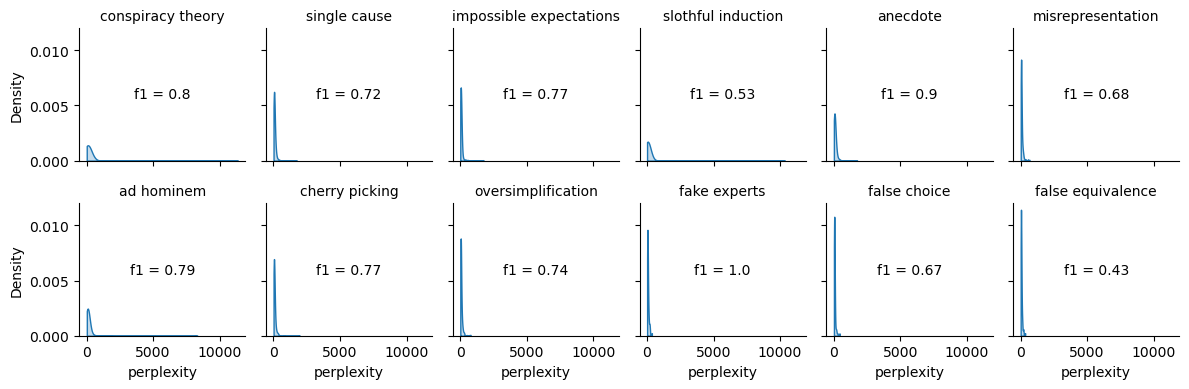

In [65]:
data = pd.DataFrame({'label':label, 'perplexity':ppls, 'text':text})

g = sns.FacetGrid(data, col="label", col_wrap=6, height=2)
g.map(sns.kdeplot, "perplexity", fill = True, cut=0)

annotation_values = {'conspiracy theory':0.80,
                     'single cause':0.72,
                     'impossible expectations':0.77,
                     'slothful induction':0.53,
                     'anecdote':0.90,
                     'misrepresentation':0.68,
                     'ad hominem':0.79,
                     'cherry picking':0.77,
                     'oversimplification':0.74,
                     'fake experts':1.00,
                     'false choice':0.67,
                     'false equivalence':0.43}

# Function to annotate each facet with a single value
for i, ax in enumerate(g.axes):
    label = ax.title.get_text()
    ax.title.set_text(label.replace('label = ', ''))
    for l, f1 in annotation_values.items():
        if l in label:
            ax.text(.5, .5, f"f1 = {f1}" ,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            break

plt.show()

In [66]:
labels = data['label'].unique()
label = 'slothful induction'
results = []
data1 = data[data['label'] == label]['perplexity']


# Perform the Mann-Whitney U test and collect results
for other_label in labels[labels != label]:
    data2 = data[data['label'] == other_label]['perplexity']
    
    stat, p = mannwhitneyu(data2, data1)
    alpha = 0.05
    if p > alpha:
        result = 'Same distribution (fail to reject H0)'
    else:
        result = 'Different distribution (reject H0)'
    
    results.append({
        'Label': other_label,
        'Statistics': stat,
        'p-value':round(p,2),
        'Result': result
    })

# Create a DataFrame from the results
pd.DataFrame(results)

,Label,Statistics,p-value,Result
0,conspiracy theory,37302.0,0.00,Different distribution (reject H0)
1,single cause,47517.0,0.00,Different distribution (reject H0)
2,impossible expectations,25141.0,0.95,Same distribution (fail to reject H0)
3,anecdote,36146.0,0.00,Different distribution (reject H0)
4,misrepresentation,29791.0,0.01,Different distribution (reject H0)
5,ad hominem,64133.0,0.00,Different distribution (reject H0)
6,cherry picking,43167.0,0.01,Different distribution (reject H0)
7,oversimplification,27057.0,0.08,Same distribution (fail to reject H0)
8,fake experts,8293.0,0.45,Same distribution (fail to reject H0)
9,false choice,8335.0,0.89,Same distribution (fail to reject H0)


In [72]:
data.sort_values('perplexity', ascending=False).head(15)

,label,perplexity,text
148,conspiracy theory,11363.084961,Climate change hoax you mean cowboy
1904,slothful induction,10358.657227,"Science never settled, consensus theater"
1860,ad hominem,8314.980469,"""climate crisis""...Drama Queens"
277,cherry picking,1963.799316,reefs are improving
715,conspiracy theory,1782.109009,What about the dem climate change scam#CarbonT...
850,ad hominem,1757.584839,What climate change? All you Fkers are buying ...
386,anecdote,1748.527588,Global warming my ass this mf cold as hell
1481,single cause,1747.223267,How could earth possibly warm unlessthe Sun go...
2268,impossible expectations,1747.092529,Shutting down Britain saves 1% carbon?
1562,ad hominem,1600.788330,mann fixed his hockey stick numbers
